(Testscenes)=
# Evaluation on Simulated test scenes

In the CIMR DEVALGO project, we have developed a set of test scenes to evaluate the performance of the algorithms. The test scenes evaluated here in the SIT ATBD, are the Test scene 1 (radiometric scene), Test scene 2 (geometric scene) and the polar scene from the SCEPS project. The test scenes are simulated scenes with known ground truth, and are used to evaluate the performance of the algorithm. The test scenes are described in the following sections.

## Test scene 1 (Radiometric scene)
The test scene 1 contains nine different surface classes, each with its own set of brightness temperatures. For the generation of these brightness temperatures a simple forward model was used, dependent on the surface type. Technically, the scene can be evaluated with unknown surface properties ignoring the surface classes. However, for an overview, these classes are shown in figure {numref}`surface_classes_scene1`.



In [1]:
using Revise
using Pkg
Pkg.activate("../sit_atbd_env_jl")
using Proj 
using Optim 
using PythonPlot
pyplot.ioff()
using Statistics
using ImageFiltering 

includet("../algorithm/sitalgorithm.jl")
includet("../algorithm/CIMR_IO_tools.jl")

fns = (; scene1=
        (; l1b="/mnt/spaces/Projects/2022_CIMR-DEVALGO/CIMR_L1X/W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc",
            input="/mnt/spaces/Projects/2022_CIMR-DEVALGO/Test_scenes_downscaled_projected_20230923/test_scene_1_compressed_lowres.nc"),
        scene2=
        (; l1b="/mnt/spaces/Projects/2022_CIMR-DEVALGO/CIMR_L1X/W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc",
            input="/mnt/spaces/Projects/2022_CIMR-DEVALGO/Test_scenes_downscaled_projected_20230923/test_scene_2_compressed_lowres.nc"),
        scenep=
        (;
            l1b="/mnt/spaces/Projects/2022_CIMR-DEVALGO/SCEPS_l1b_sceps_geo_polar_scene_1_unfiltered_tot_minimal_nom_nedt_apc_tot_v2p1.nc",
            input="/mnt/spaces/Projects/2022_CIMR-DEVALGO/cimr_sceps_toa_card_devalgo_polarscene_1_20161217_v2p0_aa_000.nc",
            geo="/mnt/spaces/Projects/2022_CIMR-DEVALGO/cimr_sceps_geo_card_devalgo_polarscene_1_20161217_harmonised_v2p0_surface.nc"
        )
)



pygc = pyimport("gc")
pr = pyimport("pyresample")
#cfeature = pyimport("cartopy.feature")
basemap= pyimport("mpl_toolkits.basemap")
LLtoEASE2n = Proj.Transformation("epsg:4326", "epsg:6931")
EASE2NtoLL = inv(LLtoEASE2n)

lltoxy=LLtoEASE2n #conversion from lat/lon to EASE2 grid coordinates
xytoll=EASE2NtoLL #conversion from EASE2 grid coordinates to lat/lon
lea = pr.geometry.AreaDefinition("ease2_nh_testscene","ease2_nh_testscene","ease2_nh_testscene","EPSG:6931",1400,1400,[0,-1.5e6,1.4e6,-1e5]) # uses pyresample to define an area definition for the test region in the EASE2 grid
leaextent=[lea.area_extent[0],lea.area_extent[2],lea.area_extent[1],lea.area_extent[3]] #extent for the image, since order differs from the order in the area definition

#getting the landmask for the region
lealons,lealats=lea.get_lonlats()
landmask = basemap.maskoceans(lealons,lealats,lealats,resolution="i").mask |> PyArray |> Array |> x->.~x 

#defining a cartopy crs
ccrs=lea.to_cartopy_crs();
##imports_end




  Activating project at `/mnt/pharoshome/huntemann/Projects/DEVALGO/SeaIceThickness_ATBD_V2/sit_atbd_env_jl`


Python:
<Projected CRS: EPSG:6931>
Name: WGS 84 / NSIDC EASE-Grid 2.0 North
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere.
- bounds: (-180.0, 0.0, 180.0, 90.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 North
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

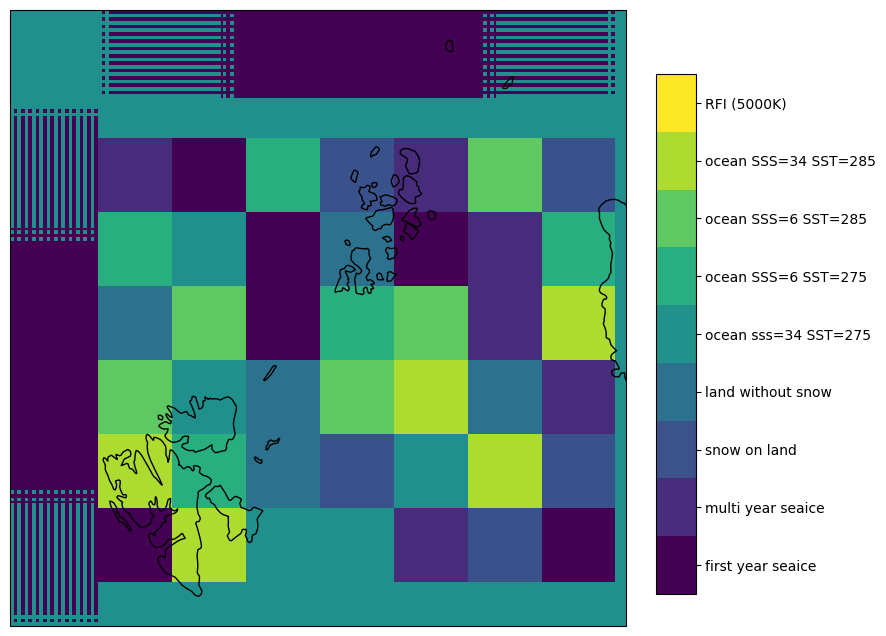

~~~markdown
```{figure} figures/figure_surface_classes_scene1.png
:name: surface_classes_scene1

Overview of surface types on Test Scene 1
```

~~~

In [2]:
testinput, mea, imextent, surfaces=read_testscene(fns.scene1.input)

surface_names=["first year seaice",
"multi year seaice",
"snow on land",
"land without snow",
"ocean sss=34 SST=275",
"ocean SSS=6 SST=275",
"ocean SSS=6 SST=285",
"ocean SSS=34 SST=285",
"RFI (5000K)"]

cmap = matplotlib.cm.get_cmap("viridis", 9)

fig = pyplot.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=ccrs)
im=ax.imshow(surfaces[end:-1:1,:], extent=imextent, cmap=cmap,interpolation="nearest",vmin=0.5,vmax=9.5)

cbar_ax = fig.add_axes([0.85, 0.15, 0.04, 0.65])

cbar = fig.colorbar(im, cax=cbar_ax, ticks=1:9, orientation="vertical")
#now only show the range 0.5 to 9.5 area of the colorbar, so the surface names are centered for each color and there is no unused color
cbar.set_ticks(1:9)
cbar.ax.set_yticklabels(surface_names)

ax.coastlines();


#pyplot.savefig("figures/surfaces_scene1.png",dpi=200,bbox_inches="tight")



#display("image/png",fig)
plot_with_caption(fig,"Overview of surface types on Test Scene 1.","surface_classes_scene1")
nothing

In [3]:
datadict=Dict()
for dir in ["forward","backward"]
    datadict[dir]=get_data_for_band(fns.scene1.l1b,"L_BAND", dir, oza_corr=false,verbose=true)
end

nedt not found, using 1.0K as uncertainty for h and v.
nedt not found, using 1.0K as uncertainty for h and v.


In [4]:
function grid_to_scene(fn,dir="forward";kwargs...)

    if dir in ["forward","backward"]
        (;h,v,lat,lon)=get_data_for_band(fn,"L_BAND", dir;kwargs...)
        ssit,sit_error=comb_error_2.(h,v) |> x->(first.(x),last.(x))
    elseif dir=="combined"
        fw=get_data_for_band(fn,"L_BAND", "forward";kwargs...)
        bw=get_data_for_band(fn,"L_BAND", "backward";kwargs...)
        h = [fw.h; bw.h]
        v = [fw.v; bw.v]
        lat = [fw.lat; bw.lat]
        lon = [fw.lon; bw.lon]
        ssit,sit_error=comb_error_2.(h,v) |> x->(first.(x),last.(x))
    end


    swath=pr.geometry.SwathDefinition(lons=lon,lats=lat)
    #resampling simulator data to grid
    sit_grid=pr.kd_tree.resample_nearest(swath, np.array(ssit), lea, radius_of_influence=50000, fill_value=NaN)
    sit_error_grid=pr.kd_tree.resample_nearest(swath, np.array(sit_error), lea, radius_of_influence=50000, fill_value=NaN)

    return sit_grid |> PyArray |> Array, sit_error_grid |> PyArray |> Array
end

function read_testscene_gridded(truthfn)
    if occursin("sceps",truthfn)
        truth=read_testscene_sceps(truthfn)
    else 
        truth=read_testscene(truthfn)
    end
    tbv=truth[1][:,1]
    tbh=truth[1][:,2]
    ssit,sit_error=comb_error_2.(tbh,tbv) |> x->(first.(x),last.(x))
    truth_gridded=ssit |> x-> reshape(x,1400,1400) 
    truth_error_gridded=sit_error |> x-> reshape(x,1400,1400)
    if occursin("sceps",truthfn)
        truth_gridded=truth_gridded |> rotl90
        truth_error_gridded=truth_error_gridded |> rotl90
    else
        truth_gridded=truth_gridded[end:-1:1,:]
        truth_error_gridded=truth_error_gridded[end:-1:1,:]
    end
    return truth_gridded, truth_error_gridded
end

read_testscene_gridded (generic function with 1 method)

In [5]:

function plot_scene(fn;kwargs...)

    fig, ax = pyplot.subplots(nrows=2, ncols=2, figsize=[10, 10], subplot_kw=PyDict(Dict("projection" => ccrs)))
    leaextent = [lea.area_extent[0], lea.area_extent[2], lea.area_extent[1], lea.area_extent[3]]
    lastim=nothing

    for (j,direction) in  enumerate(["backward","forward"])

        cimg,cimg_err = grid_to_scene(fn, direction; kwargs...)

        ax[j-1][0].imshow(cimg, extent=leaextent, origin="upper",transform=ccrs, cmap="gray", vmin=0, vmax=200,interpolation="nearest")
        ax[j-1][0].set_title("SIT $direction")
        ax[j-1][0].coastlines(color="red")

        lastim= ax[j-1][1].imshow(cimg_err, extent=leaextent, origin="upper", transform=ccrs, cmap="gray", vmin=0, vmax=200,interpolation="nearest")
        ax[j-1][1].set_title("SIT error $direction")
        ax[j-1][1].coastlines(color="red")

    end
    fig.subplots_adjust(wspace=0.01,hspace=0.08)

    cb=fig.colorbar(lastim,orientation="horizontal",ax=ax,pad=0.01,shrink=0.8)#it does not matter which image we use for the colorbar, they have the same color scale
    cb.set_label("SIT [cm]")


    return fig
end


function plot_scene_vs_truth(fn,truthfn;kwargs...)

    fig, ax = pyplot.subplots(nrows=1, ncols=3, figsize=[10, 10], subplot_kw=PyDict(Dict("projection" => ccrs)))
    leaextent = [lea.area_extent[0], lea.area_extent[2], lea.area_extent[1], lea.area_extent[3]]
    lastim=nothing
    direction="combined"
        cimg,cimg_err = grid_to_scene(fn, direction; kwargs...)
        truth_gridded,truth_err = read_testscene_gridded(truthfn)


        lastim= ax[0].imshow(truth_gridded, extent=leaextent, origin="upper", transform=ccrs, cmap="gray", vmin=0, vmax=200,interpolation="nearest")
        ax[0].set_title("SIT on CIMR input [cm]")
        ax[0].coastlines(color="red")
        fig.colorbar(lastim,orientation="horizontal",pad=0.01,shrink=0.8)

        lastim=ax[1].imshow(cimg, extent=leaextent, origin="upper",transform=ccrs, cmap="gray", vmin=0, vmax=200,interpolation="nearest")
        ax[1].set_title("SIT on CIMR output [cm]")
        ax[1].coastlines(color="red")
        fig.colorbar(lastim,orientation="horizontal",pad=0.01,shrink=0.8)

        #now the difference
        lastim= ax[2].imshow(cimg-truth_gridded, extent=leaextent, origin="upper", transform=ccrs, cmap="RdBu_r", vmin=-100, vmax=100,interpolation="nearest")
        ax[2].set_title("SIT difference [cm]")
        ax[2].coastlines(color="gray")
        fig.colorbar(lastim,orientation="horizontal",pad=0.01,shrink=0.8)


        

    fig.subplots_adjust(wspace=0.01,hspace=0.08)

    #it does not matter which image we use for the colorbar, they have the same color scale
    #cb.set_label("SIT [cm]")


    return fig
end




plot_scene_vs_truth (generic function with 1 method)

{numref}`sit_comparison_scene1` shows the comparison between the retrieval applied to the brightness temperatures which where input to the satellite simulator on the left. This serves as ground truth for the scene 1 comparison. Here, no footprint or antenna pattern is taken into account and the resulting retrieval looks crisp and sharp. 
In the center, the retrieval on the output of the CIMR satellite simulator is shown. The pattern is smoothed out due to the footprint and antenna pattern. The retrieval is still able to retrieve the main features of the scene. The major difference is seen in the intermediate sea ice concentrations of about 50 % which are present in the stripes on the top and left border of the scene. These are retrieved as very thin ice (barely distinguishable from open water) due to the non-linearity of the retrieval. 
On the right, the difference between the two retrievals is shown. The difference is mainly due to the smoothing of the scene and the non-linearity of the retrieval. While mostly blue (underestimation of ice thickness), there is a slight hint of red (overestimation) at each edge. This is over open water where the footprint still sees some ice which then barely has any influence on the retrieval but only shifts it slightly above the 0 cm ice thickness which is retrieved for open water.

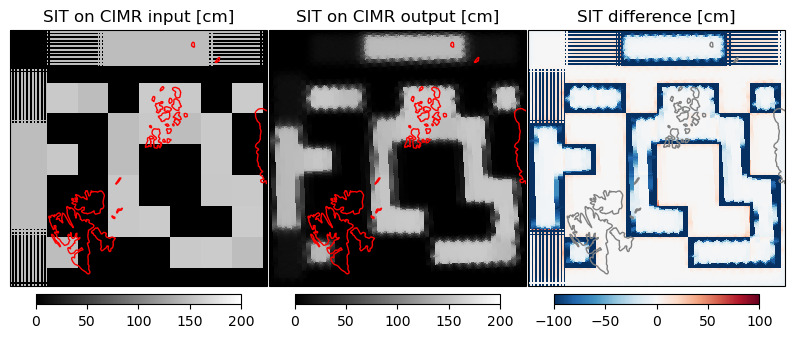

~~~markdown
```{figure} figures/figure_sit_comparison_scene1.png
:name: sit_comparison_scene1

Comparison of SIT retrieval on input to the CIMR satellite simulator (left) and on it's output (center) together with their differences (right)
```

~~~

In [6]:

plot_scene_vs_truth(fns.scene1.l1b,fns.scene1.input) |> x->plot_with_caption(x,"Comparison of SIT retrieval on input to the CIMR satellite simulator (left) and on it's output (center) together with their differences (right).","sit_comparison_scene1")

Since the CIMR satellite simulator distinguishes between the forward and backward scan, we can seperrate the retrieval into the two directions in {numref}`sit_directions_scene1`. 
While in the original SIT retrieval (and brightness temperatures) the structures in scene 1 were strait, when selecting only forward or backward scan directions, the structures become curved depending on the the scan direction. 
This was not so much visible in {numref}`sit_comparison_scene1` when both directions were combined, even though using only  nearest neighbor resampling.
This might also be due to the fact that in the L1b data which was taken as input, every sample along the scan line was available individually while having a physical overlap.
In the planned L1b data format, five samples are combined to one, which might affect the impression of the scan line appearance.
On the right side of {numref}`sit_directions_scene1` the retrieval uncertainty is shown. As can be seen, high ice thicknesses also yield high uncertainties, even larger than the ice thickness itself. This is due to the extension of the retrieval to the full range of possible ice thicknesses.

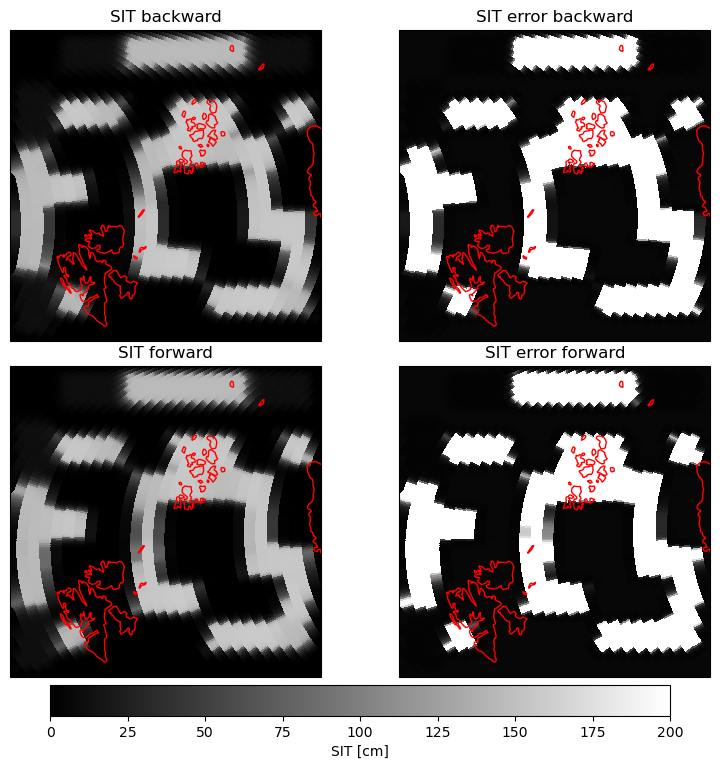

~~~markdown
```{figure} figures/figure_sit_directions_scene1.png
:name: sit_directions_scene1

SIT retrieval on the CIMR satellite simulator output for test scene 1 (radiometric scene)
```

~~~

In [7]:
plot_scene(fns.scene1.l1b,oza_corr=true) |> x->plot_with_caption(x,"SIT retrieval on the CIMR satellite simulator output for test scene 1 (radiometric scene).","sit_directions_scene1")

## Scene 2 (Geometric scene)
The scene 2 involves some star-like structures and circles which are seen nicely on the left side of {numref}`sit_comparison_scene2`. 
Only one ice type and ocean type is present in this scene, so the retrieval shows only two different values for the ice thickness with all details and sharp edges. In the center of {numref}`sit_comparison_scene2` the retrieval on the CIMR satellite simulator output is shown. Here the influence of the footprint size of L-band is strongly influencing the result. The thin star-like structures on the bottom (ice on water background) are barely visible as their area fraction on an L-band footprint is very small. Also the non-linearity of the retrieval causes the strong underestimation of the ice thickness for the lower part of the scene. Likewise, in the upper part of the screen, the star-like structures (water on ice background) are expanding due to the non-linearity of the retrieval. The difference map on the right of {numref}`sit_comparison_scene2` reflects this underestimation of ice thickness across the scene, again with a slight overestimation at the edges.

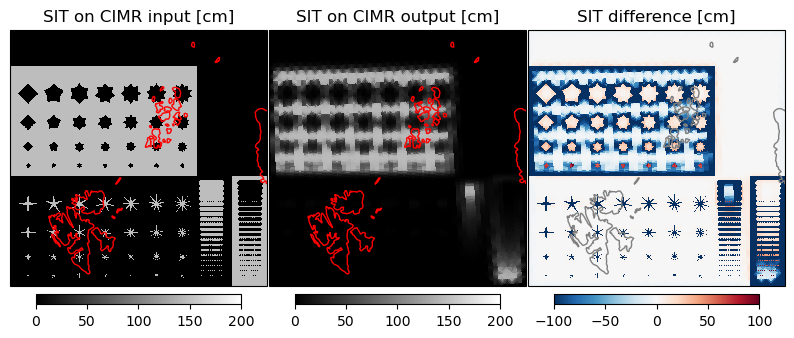

~~~markdown
```{figure} figures/figure_sit_comparison_scene2.png
:name: sit_comparison_scene2

Comparison of SIT retrieval on input to the CIMR satellite simulator (left) and on it's output (center) together with their differences (right)
```

~~~

In [8]:
plot_scene_vs_truth(fns.scene2.l1b,fns.scene2.input) |> x->plot_with_caption(x,"Comparison of SIT retrieval on input to the CIMR satellite simulator (left) and on it's output (center) together with their differences (right).","sit_comparison_scene2")

Comparing forward and backward scan for scene 2 in {numref}`sit_directions_scene2`, the star-like structures are are not recognizable in their shape and take a curvy structure in each forward and backward scan. The retrieval uncertainty on the right side of {numref}`sit_directions_scene2` shows the same behavior as in scene 1, with high ice thicknesses yielding high uncertainties.

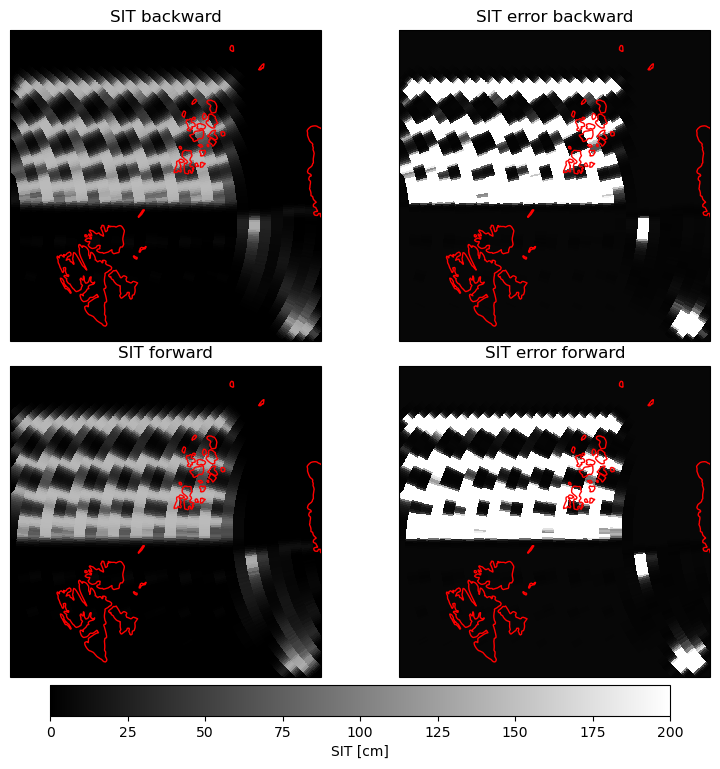

~~~markdown
```{figure} figures/figure_sit_directions_scene2.png
:name: sit_directions_scene2

SIT retrieval on the CIMR satellite simulator output for test scene 2 (geometric scene)
```

~~~

In [9]:
plot_scene(fns.scene2.l1b) |> x->plot_with_caption(x,"SIT retrieval on the CIMR satellite simulator output for test scene 2 (geometric scene).","sit_directions_scene2")

## SCEPS polar scene

The SCEPS polar scene is located in the same region as the DEVALGO test scenes 1 and 2 but is based on model data and corresponding simulated brightness temperatures. The retrieval on the input brightness temperatures to the SCEPS CIMR satellite simulator is shown on the left side of {numref}`sit_comparison_polar`. The structure contains unnatural curves but also resonable ice structures in particular around Franz Josef Land. The retrieval on the output of the CIMR satellite simulator is shown in the center of {numref}`sit_comparison_polar`. The retrieval is able to retrieve the main features of the scene and in this scene the non-linearity of the retrieval is not that influential as on the other scenes as here, open water borderes thin ice areas, so that the effect of smoothing is reduced. The difference map on the right side of {numref}`sit_comparison_polar` shows the underestimation of ice thickness in the center of the scene and the overestimation at the edges and regime changes in ice thickness. A slight overestimation is visible in the thicker ice area, which could be due to a slight warm bias in the simulated brightness temperatures output of the CIMR satellite simulator.

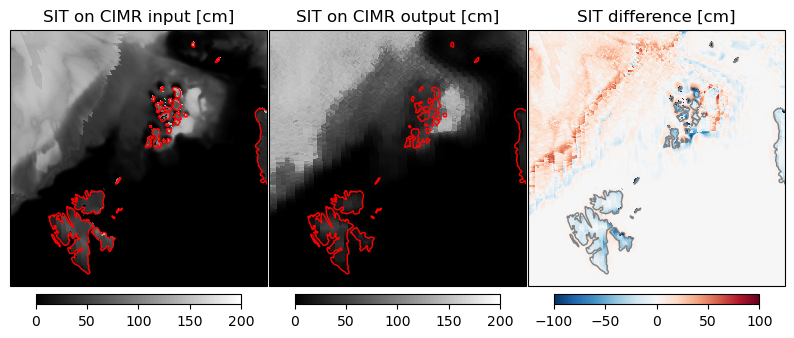

~~~markdown
```{figure} figures/figure_sit_comparison_polar.png
:name: sit_comparison_polar

Comparison of SIT retrieval on input to the CIMR satellite simulator (left) and on it's output (center) together with their differences (right)
```

~~~

In [10]:
plot_scene_vs_truth(fns.scenep.l1b,fns.scenep.input) |> x->plot_with_caption(x,"Comparison of SIT retrieval on input to the CIMR satellite simulator (left) and on it's output (center) together with their differences (right).","sit_comparison_polar")

For completeness, we also compare the retrieval on the forward and backward scans of the the SCEPS polar scene in {numref}`sit_directions_polar`. In the forward scan, the scanline is alligned with the ice edge which gives an unnatural appearance to the ice edge. This is not that pronounced in the backward scan as the scannline is perpendicular to the ice edge. The retrieval uncertainty on the right side of {numref}`sit_directions_polar` shows the same behavior as in the other scenes, with high ice thicknesses yielding high uncertainties. In general, also in the SCEPS polar scene, the combined forward and backward scan retrieval ({numref}`sit_comparison_polar` center) gives a more realistic appearance of the ice edge and more fine grained features than the individual forward or backward scan retrieval.

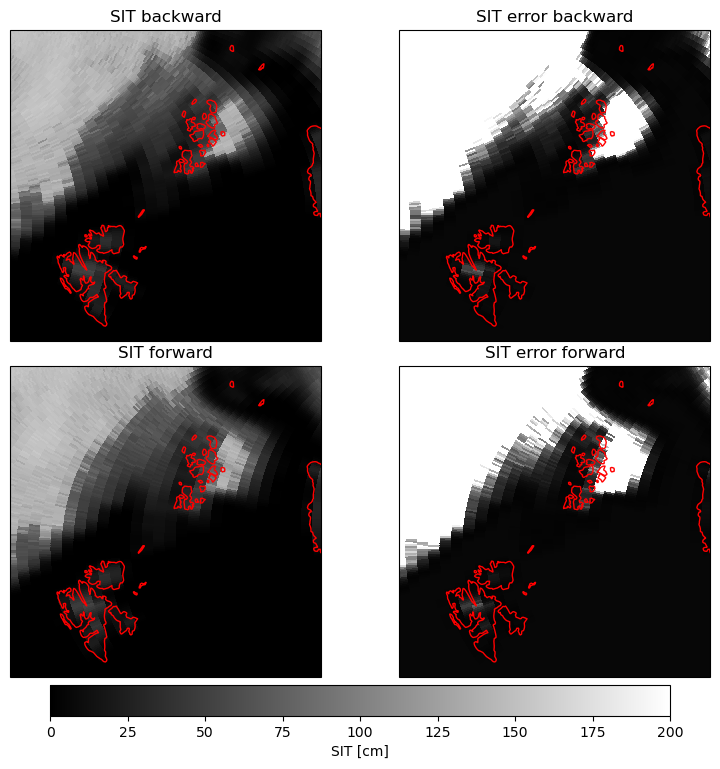

~~~markdown
```{figure} figures/figure_sit_directions_polar.png
:name: sit_directions_polar

SIT retrieval on the CIMR satellite simulator output for the SCEPS polar scene
```

~~~

In [11]:
plot_scene(fns.scenep.l1b) |> x->plot_with_caption(x,"SIT retrieval on the CIMR satellite simulator output for the SCEPS polar scene.","sit_directions_polar")

In [12]:
gdata_true,latt,lont = let
    #fn="/home/huntemann/CIMR_L1X/cimr_sceps_geo_card_polarscene_1_20161217_v1p0_part1.nc"
   fn="/mnt/spaces/Projects/2022_CIMR-DEVALGO/cimr_sceps_geo_card_devalgo_polarscene_1_20161217_harmonised_v2p0_surface.nc"

   NCDataset(fn)["sea_ice_thickness"][:,:,1][end:-1:1,:]*100.0f0,
   NCDataset(fn)["latitude"][:,:,1][end:-1:1],
   NCDataset(fn)["longitude"][:,:,1][end:-1:1]
end;

### Comparison to reference data on SCEPS polar scene

The reference data for the polar scene is also provided from SCEPS and was used to simulate corresponding brightness temperatures which are input to the retrieval and to the satellite simulator. The reference SIT data is shown in {numref}`sit_comparison_polar_reference` on the left side. The reference ice thickness seem reasonable with thin ice around Franz Josef Land and thicker sea ice towards the North pole. The retrieval output (same as in {numref}`sit_comparison_polar`) is shown in the center of {numref}`sit_comparison_polar_reference` together with the difference on the right. The major difference is seen in the underestimation of ice thickness in the center of the scene at the ice edge, but also the ice at Franz Josef Land is highly overestimated by the retrieval.

```{note}
Here the reference data set is not an absolute truth. We can only compare the retrieval to the reference data, but we cannot say which one is more accurate or closer to the truth.
```

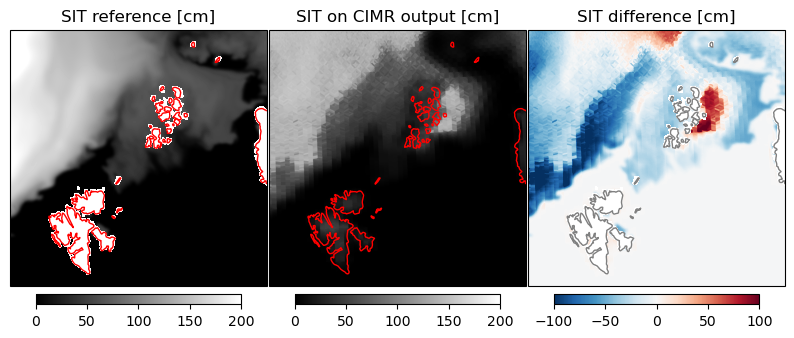

~~~markdown
```{figure} figures/figure_sit_comparison_polar_reference.png
:name: sit_comparison_polar_reference

Comparison of reference SIT on the SCEPS polar scene (left) and the retrieval applied to the SCEPS CIMR simulator (center) together with their differences (right)
```

~~~

In [13]:

let fn= fns.scenep.l1b, truth=gdata_true
    fig, ax = pyplot.subplots(nrows=1, ncols=3, figsize=[10, 10], subplot_kw=PyDict(Dict("projection" => ccrs)))
    leaextent = [lea.area_extent[0], lea.area_extent[2], lea.area_extent[1], lea.area_extent[3]]
    lastim=nothing
    direction="combined"
    cimg,cimg_err = grid_to_scene(fn, direction, oza_corr=true)
    
    truth_gridded=truth 

    lastim= ax[0].imshow(truth_gridded, extent=leaextent, origin="upper", transform=ccrs, cmap="gray", vmin=0, vmax=200)
    ax[0].set_title("SIT reference [cm]")
    ax[0].coastlines(color="red")
    fig.colorbar(lastim,orientation="horizontal",pad=0.01,shrink=0.8)

    lastim=ax[1].imshow(cimg, extent=leaextent, origin="upper",transform=ccrs, cmap="gray", vmin=0, vmax=200)
    ax[1].set_title("SIT on CIMR output [cm]")
    ax[1].coastlines(color="red")
    fig.colorbar(lastim,orientation="horizontal",pad=0.01,shrink=0.8)

    #now the difference
    lastim= ax[2].imshow(cimg-truth_gridded, extent=leaextent, origin="upper", transform=ccrs, cmap="RdBu_r", vmin=-100, vmax=100)
    ax[2].set_title("SIT difference [cm]")
    ax[2].coastlines(color="gray")
    fig.colorbar(lastim,orientation="horizontal",pad=0.01,shrink=0.8)

    fig.subplots_adjust(wspace=0.01,hspace=0.08)



    fig |> x->plot_with_caption(x,"Comparison of reference SIT on the SCEPS polar scene (left) and the retrieval applied to the SCEPS CIMR simulator (center) together with their differences (right).","sit_comparison_polar_reference")
end

In [14]:
scenep_retrieved= grid_to_scene(fns.scenep.l1b,"combined", oza_corr=true)[1]
scenep_truth = read_testscene_gridded(fns.scenep.input)[1]
scenep_reference = gdata_true

scene1_retrieved= grid_to_scene(fns.scene1.l1b, "combined", oza_corr=false)[1]
scene1_truth = read_testscene_gridded(fns.scene1.input)[1]
scene2_retrieved= grid_to_scene(fns.scene2.l1b, "combined", oza_corr=false)[1]
scene2_truth = read_testscene_gridded(fns.scene2.input)[1];

#set 100 border pixel to NAN for scene1 and scene2
scene1_retrieved[1:100,:].=NaN
scene1_retrieved[end-100:end,:].=NaN
scene1_retrieved[:,1:100].=NaN
scene1_retrieved[:,end-100:end].=NaN

scene2_retrieved[1:100,:].=NaN
scene2_retrieved[end-100:end,:].=NaN
scene2_retrieved[:,1:100].=NaN
scene2_retrieved[:,end-100:end].=NaN





1400×101 view(::Matrix{Float64}, :, 1300:1400) with eltype Float64:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
   ⋮                        ⋮            ⋱         ⋮                        ⋮
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  

## Summary
In {numref}`performance_table`, the algorithm performance on input and output is compared by applying the algorithm to both, input and output TBs of the CIMR satellite simulator. Their difference is calculated and the mean and standard deviation of the difference is shown in the table together with the mean SIT of the scene. In addition, for the SCEPS polar scene, the reference SIT is used for the comparison in the last row of the table.
In scene 1 and scene 2, the difference is negative on average, This is because there is mainly an underestimation of the SIT, as the satellite simulator smoothens the TBs and can create intermediate brightness temperatures. Over open water close to the ice edge, the SIT is overestimated, while over thick ice, close to open water the underestimation of the ice thickness is not tha pronounced.

In [15]:
using Markdown

myst_markdown = """
```{list-table} Performance comparison on the different scenes for the forward and backward comibined retrieval. The mean and standard deviation of the difference between the retrieved and the true SIT (retrieval on simulator input TBs or reference data set) is given.
:header-rows: 1
:name: performance_table

* - Scene
  - mean true SIT [cm]
  - mean difference [cm]
  - std difference [cm]
* - Scene 1
  - $(@sprintf("%.2f", mean(filter(isfinite, scene1_truth))))
  - $(@sprintf("%.2f", mean(filter(isfinite, scene1_retrieved .- scene1_truth))))
  - $(@sprintf("%.2f", std(filter(isfinite, scene1_retrieved .- scene1_truth))))
* - Scene 2
  - $(@sprintf("%.2f", mean(filter(isfinite, scene2_truth))))
  - $(@sprintf("%.2f", mean(filter(isfinite, scene2_retrieved .- scene2_truth))))
  - $(@sprintf("%.2f", std(filter(isfinite, scene2_retrieved .- scene2_truth))))
* - Scene P
  - $(@sprintf("%.2f", mean(filter(isfinite, scenep_truth))))
  - $(@sprintf("%.2f", mean(filter(isfinite, scenep_retrieved .- scenep_truth))))
  - $(@sprintf("%.2f", std(filter(isfinite, scenep_retrieved .- scenep_truth))))
* - Scene P (reference)
  - $(@sprintf("%.2f", mean(filter(isfinite, scenep_reference))))
  - $(@sprintf("%.2f", mean(filter(isfinite, scenep_retrieved .- scenep_reference))))
  - $(@sprintf("%.2f", std(filter(isfinite, scenep_retrieved .- scenep_reference))))
```
""" 
#println(myst_markdown)
display("text/markdown",myst_markdown)

```{list-table} Performance comparison on the different scenes for the forward and backward comibined retrieval. The mean and standard deviation of the difference between the retrieved and the true SIT (retrieval on simulator input TBs or reference data set) is given.
:header-rows: 1
:name: performance_table

* - Scene
  - mean true SIT [cm]
  - mean difference [cm]
  - std difference [cm]
* - Scene 1
  - 75.05
  - -24.98
  - 49.63
* - Scene 2
  - 49.20
  - -25.91
  - 48.58
* - Scene P
  - 36.19
  - 1.57
  - 13.28
* - Scene P (reference)
  - 54.46
  - -15.97
  - 27.57
```


## Special metrics

We have two special metrics, one is the evaluation of ice thickness underestimation against the distance to the closest water pixel and the other is the ice concentration within a certain radius against the ice thickness underestimation.


In [16]:
outmean = Float64[]
f10 = Float64[]
f90 = Float64[]

dists=NCDataset(fns.scene2.input)["distances"][:,:,5]|> rotl90;

mystats = let dists = Int.(round.(dists)), s2 = scene2_retrieved
    dist_vals=1:100
    true_sit=filter(isfinite, s2) |> maximum   
    #outstd = Float64[]
    #outhist= Array{Float64,2}(undef,100,151)

    bins=0:151

    for i in 1:100
        vals =true_sit .- filter(isfinite,s2[(dists.==i)])
        push!(outmean,mean(vals))
        try 
            push!(f10,quantile(vals,0.1))
            push!(f90,quantile(vals,0.9))
        catch
            push!(f10,NaN)
            push!(f90,NaN)
        end
    end
end

### Ice thickness underestimation against distance to closest water pixel
As a special metric we compute the ice the ice thickness underestimation as a function of distance to closest water for the DEVALGO test scene 2 (the geometric scene). The distance to the closest water is calculated for each pixel together with the retrieved ice thickness. For each distance bin, the mean and the 10 and 90 percentile of the ice thickness is calculated and subtracted from the true ice thickness which is the fixed value of 148 cm of for the ice used in the scene. The result is shown in {numref}`sit_error_distance_scene2` (left). The underestimation of the ice thickness is decreasing with increasing distance to the closest water pixel. A strong drop of the underestimation is visible at a distance above 40 km which is likely related to the CIMR footprint size at L-band. At 60 km distance there is barely an underestimation of ice thickness even for the 90 percentile. The right side of {numref}`sit_error_distance_scene2` shows the used scene including all used pixels. The borders of 100 km width are removed because of the 0 K brightness temperatures which were used as input outside of the simulated scene, spreading into it due to the footprint size of the simulation.

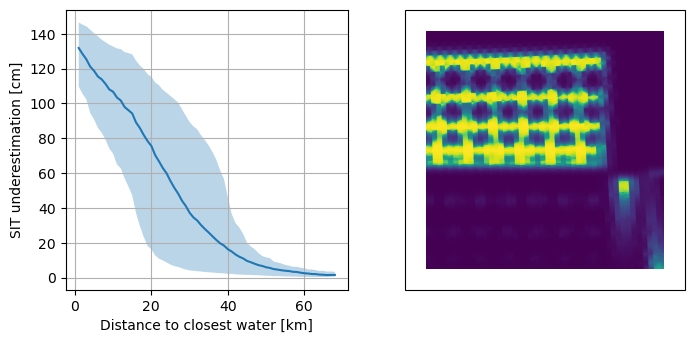

~~~markdown
```{figure} figures/figure_sit_error_distance_scene2.png
:name: sit_error_distance_scene2

Left: SIT underestimation for thick ice as a function of distance to the ice edge for scene 2. Right: retrieved SIT on scene2, 100 pixel at the edges are removed.
```

~~~

In [17]:
fig = pyplot.figure(figsize=[8, 8])
ax= fig.add_subplot(2,2,1)
ax.plot(1:100,outmean, label="mean")
ax.fill_between(1:100,f10,f90,alpha=0.3,label="10 to 90 percetile")
ax.grid()
ax.set_xlabel("Distance to closest water [km]")
ax.set_ylabel("SIT underestimation [cm]")

ax2= fig.add_subplot(2,2,2,projection=ccrs)
ax2.imshow(scene2_retrieved,extent=imextent)
#display("image/png",fig)
plot_with_caption(fig,"Left: SIT underestimation for thick ice as a function of distance to the ice edge for scene 2. Right: retrieved SIT on scene2, 100 pixel at the edges are removed.","sit_error_distance_scene2")

(concentration_influence)=
### Influence of ice concentration against ice thickness underestimation

He we compute the ice thickness underestimation as a function of ice concentration within a radius of 15 km and 50 km. To illustrate the ice concentration within a certain radius, we show the ice concentration within a radius of 15 km on the map in {numref}`ice_concentration_radius_scene2`. The shape of the features is a bit blurry due to the 15 km radius.

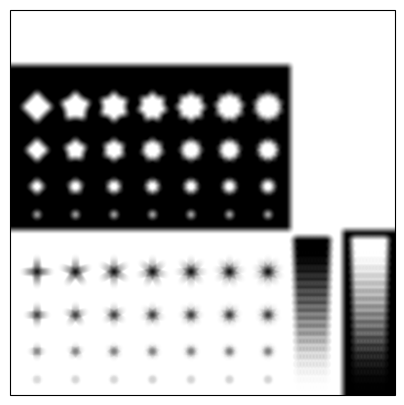

~~~markdown
```{figure} figures/figure_ice_concentration_radius_scene2.png
:name: ice_concentration_radius_scene2

Ice concentration within 15 km radius for for scene 2
```

~~~

In [18]:
fig=pyplot.figure(figsize=[5,5])
ax=fig.add_subplot(1,1,1,projection=ccrs)
ice = convert.(Float64,dists.==0)
k=15
circ_kernel=Float64[(i^2+j^2)<k^2 for i in -k:k, j in -k:k]
circ_kernel./=sum(circ_kernel)
c=imfilter(ice,circ_kernel,"replicate")
ax.imshow(c,extent=imextent,transform=ccrs,cmap="gray",vmin=0,vmax=1)
#ax.coastlines()
#display("image/png",fig)
plot_with_caption(fig,"Ice concentration within 15 km radius for for scene 2.","ice_concentration_radius_scene2")


In [19]:
s=5
steps=s:s:100
ic_mean,ic10,ic90 =let s2= grid_to_scene(fns.scene2.l1b, "combined", oza_corr=false)[1]
    ice = convert.(Float64,dists.>0)
    true_sit=filter(isfinite, s2) |> maximum   


    outdict=Dict()
    ic10=Dict()
    ic90=Dict()
    for d in [15,30,50]
        outdict[d]=Float64[]
        ic10[d]=Float64[]
        ic90[d]=Float64[]
        k=d
        circ_kernel=Float64[(i^2+j^2)<k^2 for i in -k:k, j in -k:k]
        circ_kernel./=sum(circ_kernel)
        c=imfilter(ice,circ_kernel,"replicate")
        c_r=c[100:end-100,100:end-100]
        c_r=round.(Int,c_r .* 100)
        s2_r=s2[100:end-100,100:end-100]
        for i in steps
            idx= (c_r .>=i- s/2) .&& (c_r .< i + s/2)
            push!(ic10[d],true_sit - quantile(s2_r[idx],0.1))
            push!(ic90[d],true_sit - quantile(s2_r[idx],0.9))
            push!(outdict[d],true_sit - mean(filter(isfinite,s2_r[idx])))
        end
    end
    outdict,ic10,ic90
end


(Dict{Any, Any}(50 => [147.47080144262665, 146.7718968738499, 145.7893217445369, 144.8072593091881, 143.76366991960538, 142.56746882658737, 141.27035645198134, 139.7278359669089, 137.46060742085493, 134.76114956013728, 131.95582385218535, 127.46574810480632, 121.96415958828108, 114.62202133157741, 104.68682012911398, 97.74392346967196, 70.04502868758014, 43.26142317184319, 28.46035016314933, 7.961143756341045], 15 => [144.44331450027562, 143.2708792923625, 142.27538970672154, 141.18624319844986, 139.96229825698782, 138.6054024091675, 137.4793847913441, 135.41344268900636, 133.57527387511288, 132.21922841174873, 129.42212316140672, 127.07716839624862, 124.80209519281887, 122.54338652128584, 120.3514520545096, 114.74054716719799, 110.91688603835587, 106.8771275470533, 99.6826736823004, 45.31203937087419], 30 => [146.47391247314275, 145.49699056412547, 144.79314148928322, 143.31215267906748, 142.34055408365015, 141.31975635159975, 139.77333433027275, 137.49338319849235, 135.57507664439913

The SIT underestimation as a function of ice concentration for the radius of 15 km and 50 km is shown in {numref}`sit_error_ice_concentration_scene2`. For small ice concentrations the underestimation for both radii is very high as expected. For 80 % ice concentration there is a strong drop in underestimation for the 50 km radius which occurs only beyond 90 % ice concentration for the 15 km radius. This is due to the fact that the 15 km radius is not enough to account for all the influence of the ice concentration on the SIT retrieval. Also note that the scene geometry influence this kind of analysis, as the shapes of the ice concentration features are not circular.

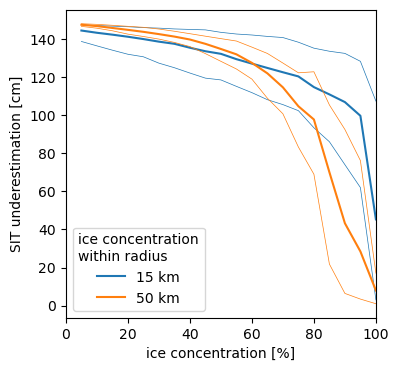

~~~markdown
```{figure} figures/figure_sit_error_ice_concentration_scene2.png
:name: sit_error_ice_concentration_scene2

SIT underestimation as a function of ice concentration for different radii around the pixel for scene 2
```

~~~

In [20]:
fig=pyplot.figure(figsize=[4,4])
ax=fig.add_subplot(111)
colors=["C0","C2","C1"]
ax.plot(steps,ic_mean[15],label="15 km",color=colors[1])
ax.plot(steps,ic10[15],color=colors[1],lw=0.5)
ax.plot(steps,ic90[15],color=colors[1],lw=0.5)
#ax.plot(steps,ic_mean[30],label="30 km",color=colors[2])
#ax.plot(steps,ic10[30],color=colors[2],lw=0.5)
#ax.plot(steps,ic90[30],color=colors[2],lw=0.5)
ax.plot(steps,ic_mean[50],label="50 km",color=colors[3])
ax.plot(steps,ic10[50],color=colors[3],lw=0.5)
ax.plot(steps,ic90[50],color=colors[3],lw=0.5)
ax.set_xlabel("ice concentration [%]")
ax.set_ylabel("SIT underestimation [cm]")
ax.legend(title="ice concentration\nwithin radius")
ax.set_xlim(0,100)
plot_with_caption(fig,"SIT underestimation as a function of ice concentration for different radii around the pixel for scene 2.","sit_error_ice_concentration_scene2")

### Summary
The results indicate that the underestimation of SIT is significantly influenced by ice concentration and the radius used for analysis, highlighting the importance of high sea ice concentration for an accurate retrieval of SIT. The findings suggest that a larger radius may be necessary to capture the full impact of ice concentration on SIT measurements, particularly in regions with varying ice distribution. The actual sea ice concentration is not part of this processing, so that its influence can not be considered here as SIT uncertainty. This analysis underscores the need for incorporating actual sea ice concentration data in future studies to better understand and quantify the uncertainties associated with SIT retrievals. Additionally, it highlights the potential for improving retrieval algorithms by integrating spatial information about ice concentration and its variability, which could lead to more accurate assessments of sea ice thickness in diverse environmental conditions.